In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
nltk.download('all')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

In [2]:
# Load the CSV file and assign column names
data = []
with open('translated_review_comments.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 2)  # Split only on the first two spaces
        if len(parts) == 3:  # Ensure no lines with missing data
            data.append(parts)
df = pd.DataFrame(data, columns=['propertyID', 'reviewID', 'comment'])

df.describe()


,propertyID,reviewID,comment
count,122853,122853,122853
unique,3408,122849,120103
top,4069429,182134929,No features in text.
freq,533,2,147


In [3]:
# Basic cleaning and preprocessing
# Assuming 'comment' column contains the text reviews
df['cleaned_comments'] = df['comment'].str.lower()
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: re.sub(r'\d+', '', x))  # remove numbers
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # remove punctuation
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df.to_csv("cleaned_review_comments.csv",index=False)

In [4]:
# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_comments'])

In [5]:
print(X.shape)
print(type(X))

(122853, 50258)
<class 'scipy.sparse._csr.csr_matrix'>


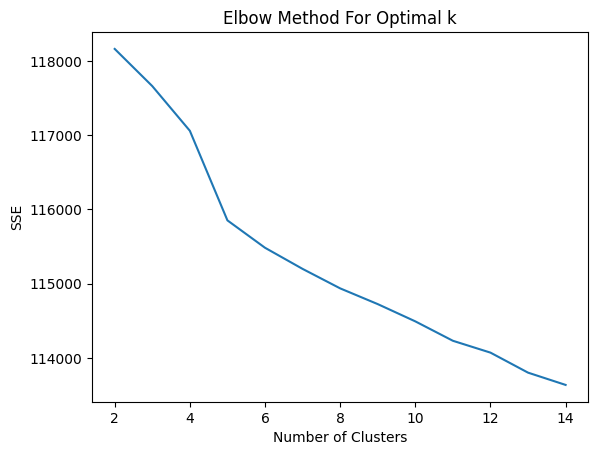

In [6]:
import matplotlib.pyplot as plt
# Elbow Method to find the optimal number of clusters
sse = {}
for k in range(2, 15):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method For Optimal k")
plt.show()




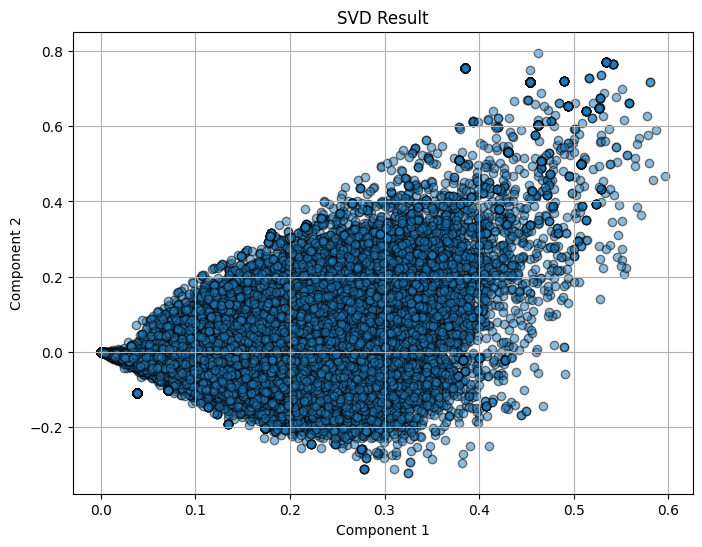

In [8]:

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


# Initialize TruncatedSVD to reduce to 2 dimensions for visualization
svd = TruncatedSVD(n_components=2)

# Fit TruncatedSVD on the TF-IDF matrix
tfidf_svd = svd.fit_transform(X)  # No need to convert to dense array

# Optionally, visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], edgecolor='k', alpha=0.5)
plt.title('SVD Result')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

In [9]:
feature_names = vectorizer.get_feature_names_out()  # Get the feature names (words)
for i in range(2):  # We are only interested in the first two components here
    print(f"Top terms in Component {i+1}:")
    component_terms = dict(zip(feature_names, svd.components_[i]))
    sorted_terms = sorted(component_terms.items(), key=lambda x: x[1], reverse=True)
    for term, weight in sorted_terms[:10]:  # Show top 10 terms
        print(f"{term}: {weight:.4f}")
    print("\n")

Top terms in Component 1:
great: 0.3854
place: 0.2714
location: 0.2605
stay: 0.2288
apartment: 0.2224
nice: 0.1791
clean: 0.1773
host: 0.1736
good: 0.1734
everything: 0.1354


Top terms in Component 2:
great: 0.7543
location: 0.2761
place: 0.1170
host: 0.0410
value: 0.0285
stay: 0.0220
awesome: 0.0144
spot: 0.0125
communication: 0.0103
amazing: 0.0062




In [11]:
from sklearn.cluster import KMeans

# Assuming 'tfidf_svd' contains your SVD-transformed TF-IDF data
# Let's cluster the documents into, for example, 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(tfidf_svd)

# Now 'clusters' contains the cluster labels for each document


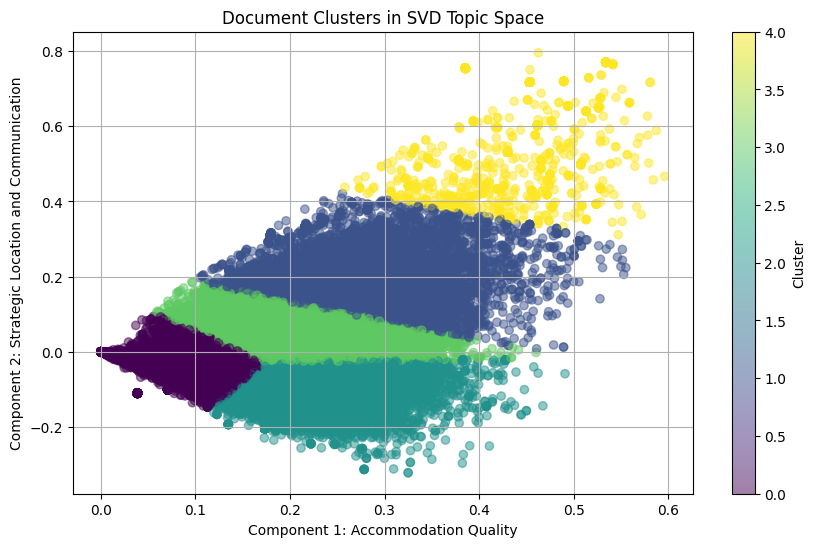

In [12]:
import matplotlib.pyplot as plt

# Plotting the document clusters in SVD topic space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Component 1: Accommodation Quality')
plt.ylabel('Component 2: Strategic Location and Communication')
plt.title('Document Clusters in SVD Topic Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()
